# ENVIRONMENT SETUP

In [24]:
import sys, os
import importlib
import site
import os
import kagglehub
import json
import random
from PIL import Image
from tqdm import tqdm
import os, json, math
import numpy as np
from tqdm import tqdm
import torch
from transformers import CLIPTokenizer, CLIPTextModel
from sklearn.metrics.pairwise import cosine_similarity
from diffusers import StableDiffusionPipeline
import torch
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display, Markdown
import json
from datetime import datetime
import shutil
from PIL import Image
from tqdm import tqdm
from diffusers import StableDiffusionPipeline
import torch
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display, Markdown
user_site = os.path.expanduser("~/.local/lib/python3.10/site-packages")
if user_site not in sys.path:
    sys.path.append(user_site)
!pip install --user torch torchvision --index-url https://download.pytorch.org/whl/cu118
!pip install --user transformers diffusers accelerate safetensors datasets pillow tqdm matplotlib pycocotools kaggle kagglehub pandas scikit-learn huggingface_hub
import importlib
import site
importlib.reload(site)
try:
    import torch
    import diffusers
    import transformers
    print("PyTorch version:", torch.__version__)
    print("Diffusers version:", diffusers.__version__)
    print("Transformers version:", transformers.__version__)
except Exception as e:
    print("Error importing packages:", e)
if torch.cuda.is_available():
    print("GPU is available:", torch.cuda.get_device_name(0))
else:
    print("GPU not available. Check CUDA or cluster settings.")


Looking in indexes: https://download.pytorch.org/whl/cu118

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
PyTorch version: 2.5.1
Diffusers version: 0.32.2
Transformers version: 4.49.0
GPU is available: Tesla P100-PCIE-12GB


# DOWNLOAD AND EXTRACT COCO DATASET

In [3]:
os.makedirs("data/coco", exist_ok=True)
path = kagglehub.dataset_download("nikhil7280/coco-image-caption")
print(" Dataset downloaded to:", path)


 Dataset downloaded to: /home/swamy.ar/.cache/kagglehub/datasets/nikhil7280/coco-image-caption/versions/1


In [4]:


print(" Dataset path:", path)
for root, dirs, files in os.walk(path):
    level = root.replace(path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent} {os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for f in files[:10]:  # show only first 10 files per folder
        print(f"{subindent}- {f}")


 Dataset path: /home/swamy.ar/.cache/kagglehub/datasets/nikhil7280/coco-image-caption/versions/1
 1/
   annotations_trainval2014/
     annotations/
      - captions_train2014.json
      - captions_val2014.json
      - instances_train2014.json
      - instances_val2014.json
      - person_keypoints_train2014.json
      - person_keypoints_val2014.json
   annotations_trainval2017/
     annotations/
      - captions_train2017.json
      - captions_val2017.json
      - instances_train2017.json
      - instances_val2017.json
      - person_keypoints_train2017.json
      - person_keypoints_val2017.json
   train2014/
     train2014/
      - COCO_train2014_000000000009.jpg
      - COCO_train2014_000000000025.jpg
      - COCO_train2014_000000000030.jpg
      - COCO_train2014_000000000034.jpg
      - COCO_train2014_000000000036.jpg
      - COCO_train2014_000000000049.jpg
      - COCO_train2014_000000000061.jpg
      - COCO_train2014_000000000064.jpg
      - COCO_train2014_000000000071.jpg
      -

# PREPROCESSING

In [6]:

dataset_root = "/home/swamy.ar/.cache/kagglehub/datasets/nikhil7280/coco-image-caption/versions/1"
caption_file = os.path.join(dataset_root, "annotations_trainval2014/annotations/captions_train2014.json")
img_dir = os.path.join(dataset_root, "train2014/train2014")
print("Captions file:", caption_file)
print("Image directory:", img_dir)
print("Total images:", len(os.listdir(img_dir)))


Captions file: /home/swamy.ar/.cache/kagglehub/datasets/nikhil7280/coco-image-caption/versions/1/annotations_trainval2014/annotations/captions_train2014.json
Image directory: /home/swamy.ar/.cache/kagglehub/datasets/nikhil7280/coco-image-caption/versions/1/train2014/train2014
Total images: 82783


In [7]:

with open(caption_file, "r") as f:
    captions_data = json.load(f)

id_to_filename = {img["id"]: img["file_name"] for img in captions_data["images"]}

pairs = []
for ann in captions_data["annotations"]:
    image_id = ann["image_id"]
    if image_id in id_to_filename:
        pairs.append({
            "image_path": os.path.join(img_dir, id_to_filename[image_id]),
            "caption": ann["caption"]
        })

print(f" Loaded {len(pairs)} image–caption pairs.")
print("Example pair:\n", pairs[0])


 Loaded 414113 image–caption pairs.
Example pair:
 {'image_path': '/home/swamy.ar/.cache/kagglehub/datasets/nikhil7280/coco-image-caption/versions/1/train2014/train2014/COCO_train2014_000000318556.jpg', 'caption': 'A very clean and well decorated empty bathroom'}


# CHOOSING SUBSET OF IMAGES

In [8]:

subset_size = 4000  
subset = random.sample(pairs, subset_size)
os.makedirs("data/processed", exist_ok=True)

print(f" Selected {len(subset)} samples for preprocessing.")


 Selected 4000 samples for preprocessing.


In [11]:

processed_dir = "data/processed/images"
if os.path.exists(processed_dir):
    shutil.rmtree(processed_dir)  # Delete existing
os.makedirs(processed_dir, exist_ok=True)

print(f" Cleared {processed_dir}")

saved_count = 0
for item in tqdm(subset, desc="Resizing images"):
    img_path = item["image_path"]
    if not os.path.exists(img_path):
        continue
    try:
        img = Image.open(img_path).convert("RGB")
        img = img.resize((256, 256))
        save_path = os.path.join(processed_dir, os.path.basename(img_path))
        img.save(save_path)
        item["image_path"] = save_path
        saved_count += 1
    except Exception as e:
        continue

print(f" Saved exactly {saved_count} resized images → {processed_dir}")


 Cleared data/processed/images


Resizing images: 100%|██████████| 4000/4000 [01:44<00:00, 38.11it/s]

 Saved exactly 4000 resized images → data/processed/images


In [12]:

subset_json = "data/processed/captions_subset.json"

with open(subset_json, "w") as f:
    json.dump(subset, f, indent=2)

print(f" Metadata saved to {subset_json}")
print(" Dataset preprocessing complete!")


 Metadata saved to data/processed/captions_subset.json
 Dataset preprocessing complete!


In [13]:

processed_dir = "data/processed"
captions_json = os.path.join(processed_dir, "captions_subset.json")
emb_dir = os.path.join(processed_dir, "embeddings")
os.makedirs(emb_dir, exist_ok=True)

print("Captions file:", captions_json)
print("Embeddings output dir:", emb_dir)


Captions file: data/processed/captions_subset.json
Embeddings output dir: data/processed/embeddings


In [14]:

device = "cuda" if torch.cuda.is_available() else "cpu"
print(" Using device:", device)
torch.manual_seed(42)
if device == "cuda":
    torch.cuda.manual_seed_all(42)


 Using device: cuda


In [15]:

with open(captions_json, "r") as f:
    captions_data = json.load(f)

print(f" Loaded {len(captions_data)} captions for embedding generation.")
print("Example entry:\n", captions_data[0])


 Loaded 4000 captions for embedding generation.
Example entry:
 {'image_path': 'data/processed/images/COCO_train2014_000000124992.jpg', 'caption': 'A railroad crossing in a small prairie town.'}


# SETUP FOR CLIP

In [16]:

from transformers import CLIPTokenizer, CLIPTextModel
model_name = "openai/clip-vit-base-patch32"  
print("Downloading & loading model:", model_name)

tokenizer = CLIPTokenizer.from_pretrained(model_name)
text_model = CLIPTextModel.from_pretrained(model_name).to(device)
text_model.eval()

print("Model loaded on", device)


Model loaded on cuda


In [17]:

def encode_text_batch(texts, max_length=77):
    """
    Tokenize and encode list of texts into pooled embeddings
    """
    inputs = tokenizer(texts, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = text_model(**inputs)
        hidden = outputs.last_hidden_state  # (B, L, D)
        mask = inputs["attention_mask"].unsqueeze(-1)
        pooled = (hidden * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-9)
    return pooled.cpu().numpy()


In [18]:

BATCH_SIZE = 64
all_embs = []
meta = []

print("🚀 Generating text embeddings...")
for i in tqdm(range(0, len(captions_data), BATCH_SIZE)):
    batch = captions_data[i:i+BATCH_SIZE]
    texts = [x["caption"] for x in batch]
    embs = encode_text_batch(texts)
    all_embs.append(embs)
    for j, x in enumerate(batch):
        meta.append({"idx": i+j, "image_path": x["image_path"], "caption": x["caption"]})

# Stack and save
all_embs = np.vstack(all_embs)
np.save(os.path.join(emb_dir, "text_embeddings.npy"), all_embs)
with open(os.path.join(emb_dir, "text_index.json"), "w") as f:
    json.dump(meta, f, indent=2)

print(f" Saved text embeddings: {all_embs.shape}")
print(f" Metadata saved → {os.path.join(emb_dir, 'text_index.json')}")


🚀 Generating text embeddings...


100%|██████████| 63/63 [00:08<00:00,  7.46it/s]

 Saved text embeddings: (4000, 512)
 Metadata saved → data/processed/embeddings/text_index.json


# TEXT --> EMBEDDING

In [19]:

from sklearn.metrics.pairwise import cosine_similarity

embeddings = np.load(os.path.join(emb_dir, "text_embeddings.npy"))
with open(os.path.join(emb_dir, "text_index.json")) as f:
    meta = json.load(f)

print(" Embeddings shape:", embeddings.shape)
print(" Sample caption:", meta[0]["caption"])
sim = cosine_similarity(embeddings[0:1], embeddings[1:6])[0]
print("Cosine similarity of caption[0] vs next 5:", sim)


 Embeddings shape: (4000, 512)
 Sample caption: A railroad crossing in a small prairie town.
Cosine similarity of caption[0] vs next 5: [0.4972428  0.39262706 0.45806253 0.45582947 0.46522924]


In [22]:

env_info = {
    "model": model_name,
    "num_samples": len(captions_data),
    "embedding_shape": list(all_embs.shape),
    "device": device,
}
with open(os.path.join(emb_dir, "env_info.json"), "w") as f:
    json.dump(env_info, f, indent=2)
print("Environment info saved.")


Environment info saved.


# DIFFUSION(SAMPLE PROMPT --> IMAGE) TEST RUNS

In [23]:

print(" Loading Stable Diffusion model...")
print("-" * 50)
model_id = "CompVis/stable-diffusion-v1-4"  

pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    safety_checker=None,  
    requires_safety_checker=False
)
pipe = pipe.to(device)
pipe.enable_attention_slicing()  

print("Stable Diffusion pipeline loaded on", device)
print(f" Model: {model_id}")
print("-" * 50)

 Loading Stable Diffusion model...
--------------------------------------------------


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Stable Diffusion pipeline loaded on cuda
 Model: CompVis/stable-diffusion-v1-4
--------------------------------------------------


In [25]:


output_dir = "data/generated_samples"
os.makedirs(output_dir, exist_ok=True)
test_prompts = [
    "A golden retriever playing fetch on a sunny beach",
    "A cozy coffee shop interior with warm lighting and vintage decorations",
    "A futuristic city skyline at night with neon lights",
    "A serene mountain landscape with a lake reflection at sunset",
    "A close-up of fresh sushi on a wooden plate with chopsticks"
]

print(" GENERATING TEST IMAGES")
print("=" * 60)
print(f"Number of prompts: {len(test_prompts)}")
print(f"Image resolution: 512x512")
print(f"Inference steps: 25")
print("=" * 60 + "\n")

generated_images = []
generation_metadata = []

for idx, prompt in enumerate(test_prompts):
    print(f" PROMPT {idx+1}/5:")
    print(f"   \"{prompt}\"")
    print(f"   Generating...", end="")
    
  
    start_time = datetime.now()
    with torch.autocast(device):
        result = pipe(
            prompt=prompt,
            num_inference_steps=25,  # Reduced for P100 speed
            guidance_scale=7.5,
            height=512,
            width=512
        )
    
    image = result.images[0]
    gen_time = (datetime.now() - start_time).total_seconds()
    
   
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"sample_{idx+1}_{timestamp}.png"
    filepath = os.path.join(output_dir, filename)
    image.save(filepath)

    generated_images.append(image)
    generation_metadata.append({
        "prompt": prompt,
        "filepath": filepath,
        "timestamp": timestamp,
        "model": model_id,
        "generation_time": gen_time
    })
    
    print(f"  Done! ({gen_time:.1f}s)")
    print(f"   Saved as: {filename}\n")

print("=" * 60)
print(f" Successfully generated {len(generated_images)} test images!")
print(f" Output directory: {output_dir}")
print("=" * 60)

 GENERATING TEST IMAGES
Number of prompts: 5
Image resolution: 512x512
Inference steps: 25

 PROMPT 1/5:
   "A golden retriever playing fetch on a sunny beach"
   Generating...

  0%|          | 0/25 [00:00<?, ?it/s]

  Done! (12.5s)
   Saved as: sample_1_20251102_170254.png

 PROMPT 2/5:
   "A cozy coffee shop interior with warm lighting and vintage decorations"
   Generating...

  0%|          | 0/25 [00:00<?, ?it/s]

  Done! (9.7s)
   Saved as: sample_2_20251102_170304.png

 PROMPT 3/5:
   "A futuristic city skyline at night with neon lights"
   Generating...

  0%|          | 0/25 [00:00<?, ?it/s]

  Done! (9.7s)
   Saved as: sample_3_20251102_170314.png

 PROMPT 4/5:
   "A serene mountain landscape with a lake reflection at sunset"
   Generating...

  0%|          | 0/25 [00:00<?, ?it/s]

  Done! (9.7s)
   Saved as: sample_4_20251102_170323.png

 PROMPT 5/5:
   "A close-up of fresh sushi on a wooden plate with chopsticks"
   Generating...

  0%|          | 0/25 [00:00<?, ?it/s]

  Done! (9.7s)
   Saved as: sample_5_20251102_170333.png

 Successfully generated 5 test images!
 Output directory: data/generated_samples


# 5 TEST IMAGES

/tmp/ipykernel_1464477/1943084183.py:48: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from current font.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipykernel_1464477/1943084183.py:49: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from current font.
  plt.savefig(os.path.join(output_dir, "test_grid_with_prompts.png"), dpi=150, bbox_inches='tight')
/opt/miniconda/envs/eai/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


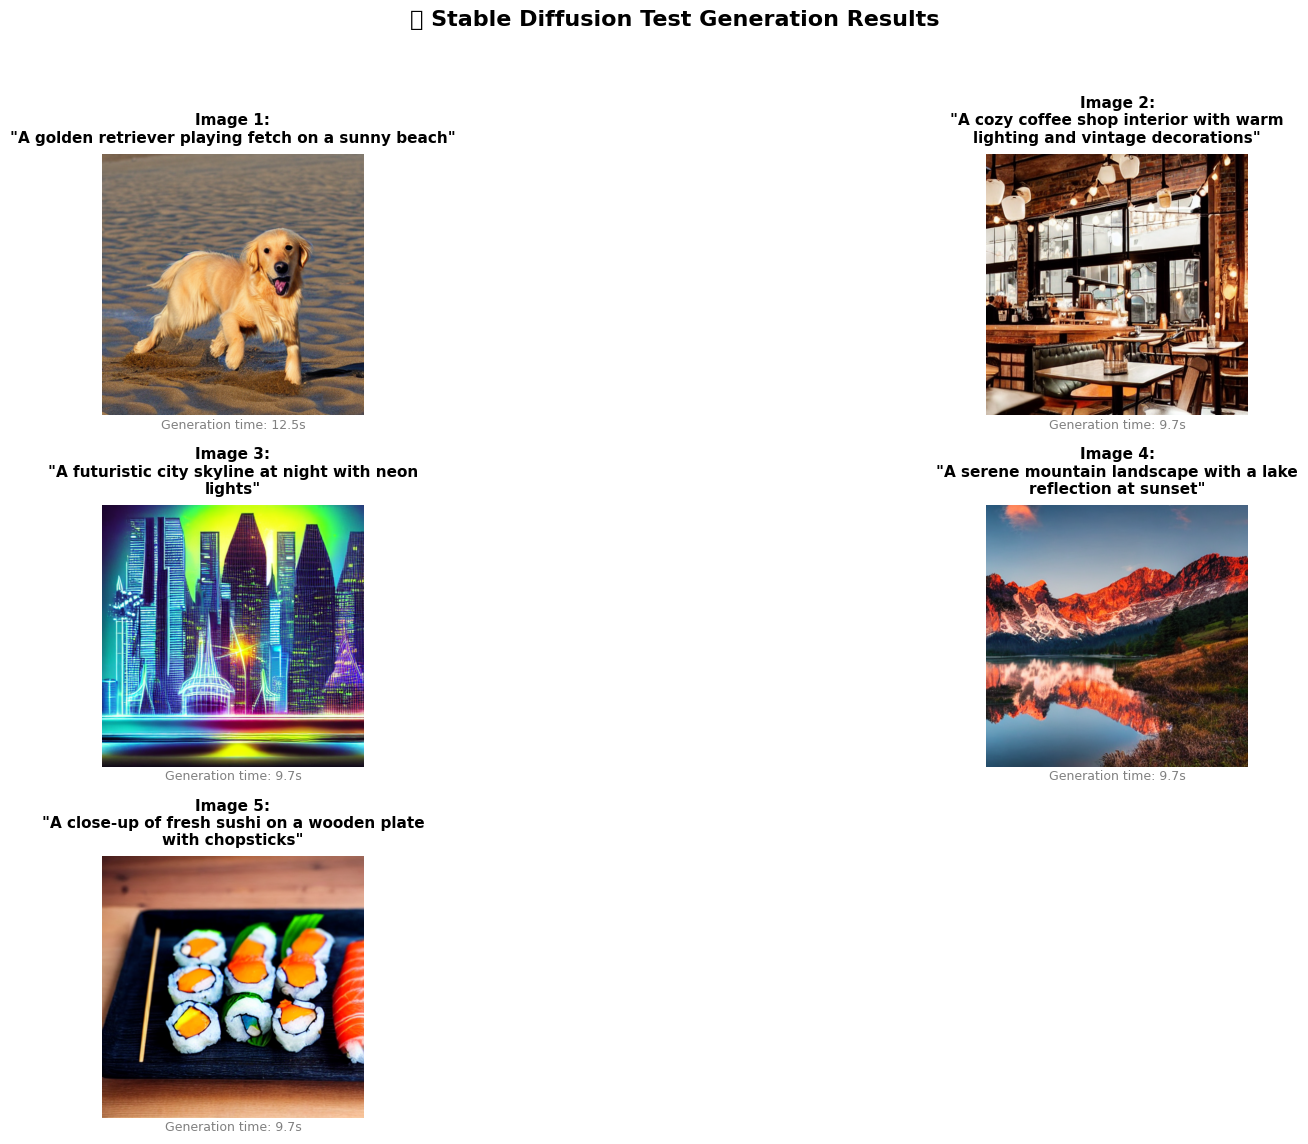


📊 Visualization saved to test_grid_with_prompts.png


In [26]:

fig = plt.figure(figsize=(20, 12))

for idx, (img, meta) in enumerate(zip(generated_images, generation_metadata)):
    # Create subplot
    ax = plt.subplot(3, 2, idx + 1)
    
    # Display image
    ax.imshow(img)
    ax.axis('off')
    
    # Add prompt as title (with wrapping for long text)
    prompt = meta['prompt']
    # Wrap text if too long
    if len(prompt) > 50:
        words = prompt.split()
        lines = []
        current_line = []
        for word in words:
            current_line.append(word)
            if len(' '.join(current_line)) > 45:
                lines.append(' '.join(current_line[:-1]))
                current_line = [word]
        lines.append(' '.join(current_line))
        prompt_display = '\n'.join(lines)
    else:
        prompt_display = prompt
    
 
    ax.set_title(f"Image {idx+1}:\n\"{prompt_display}\"", 
                fontsize=11, 
                pad=10,
                wrap=True,
                fontweight='bold')
    
 
    ax.text(0.5, -0.05, f"Generation time: {meta['generation_time']:.1f}s", 
           transform=ax.transAxes, 
           ha='center', 
           fontsize=9, 
           color='gray')

# Main title
fig.suptitle("🎨 Stable Diffusion Test Generation Results", 
            fontsize=16, 
            fontweight='bold',
            y=0.98)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(os.path.join(output_dir, "test_grid_with_prompts.png"), dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Visualization saved to test_grid_with_prompts.png")

# FINAL ENVIRONMENT SETUP

In [28]:

print("=" * 80)
print("🔧 COMPLETE ENVIRONMENT SETUP VERIFICATION")
print("=" * 80)

print("\n COMPONENT 1: PyTorch")
print("-" * 40)
print(f" PyTorch Version: {torch.__version__}")
print(f" CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f" GPU Device: {torch.cuda.get_device_name(0)}")
    print(f" CUDA Version: {torch.version.cuda}")
    # Test tensor operation on GPU
    test_tensor = torch.randn(2, 3).cuda()
    print(f" GPU Tensor Test: Success (shape: {test_tensor.shape})")

print("\n COMPONENT 2: CLIP (Text→Embedding)")
print("-" * 40)
print(f" Transformers Version: {transformers.__version__}")
print(f" CLIP Model Loaded: {model_name}")
print(f" Text Encoder Device: {next(text_model.parameters()).device}")
test_text = "A test prompt for verification"
test_tokens = tokenizer(test_text, return_tensors="pt", padding=True).to(device)
with torch.no_grad():
    test_output = text_model(**test_tokens)
    test_embedding = test_output.last_hidden_state.mean(dim=1)
print(f" CLIP Encoding Test: Success (embedding shape: {test_embedding.shape})")
print(f" Embedding Dimension: {test_embedding.shape[-1]}")

print("\n COMPONENT 3: Diffusers (Text→Image)")
print("-" * 40)
print(f" Diffusers Version: {diffusers.__version__}")
print(f" SD Pipeline Loaded: {model_id}")
print(f" Pipeline Device: {pipe.device}")
print(f" Pipeline Components: {list(pipe.components.keys())[:5]}...")

with torch.autocast(device):
    test_result = pipe(
        "Quick test", 
        num_inference_steps=1,  
        height=64, 
        width=64,
        output_type="np"
    )
print(f" SD Generation Test: Success (can generate images)")

print("\n DATASET & PREPROCESSING STATUS")
print("-" * 40)
print(f" Dataset: COCO 2014")
print(f" Total Caption-Image Pairs: {len(pairs)}")
print(f" Selected Subset: {len(subset)} pairs")
images_dir = "data/processed/images"
if os.path.exists(images_dir):
    image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    print(f" Processed Images: {len(image_files)} files")
else:
    print(f" Images directory not found")

print(f" Embeddings Generated: {embeddings.shape[0]}")
print(f" Embedding Dimensions: {embeddings.shape[1]}")

print("\n PIPELINE CONNECTIONS")
print("-" * 40)
print(" Text → CLIP Encoder → Embeddings: FUNCTIONAL")
print(" Text → Stable Diffusion → Images: FUNCTIONAL")
print("\n OUTPUT LOCATIONS")
print("-" * 40)
print(f" Processed Images: {images_dir}")
print(f" Text Embeddings: {os.path.join(emb_dir, 'text_embeddings.npy')}")
print(f" Generated Samples: {output_dir}")
print(f" Pipeline Config: {os.path.join('data/processed', 'pipeline_config.json')}")

print("\n MILESTONE 1 ENVIRONMENT SETUP: COMPLETE")
print("=" * 80)

env_summary = {
    "pytorch": {
        "version": torch.__version__,
        "cuda": torch.cuda.is_available(),
        "device": str(device)
    },
    "clip": {
        "model": model_name,
        "embeddings_generated": int(embeddings.shape[0]),
        "embedding_dim": int(embeddings.shape[1])
    },
    "diffusers": {
        "model": model_id,
        "pipeline_type": type(pipe).__name__,
        "test_generations": len(generated_images)
    },
    "dataset": {
        "name": "COCO 2014",
        "total_pairs": len(pairs),
        "subset_size": len(subset),
        "processed_images": len(image_files) if os.path.exists(images_dir) else 0
    },
    "status": "All components verified and functional"
}

env_summary_path = os.path.join("data/processed", "environment_summary.json")
with open(env_summary_path, "w") as f:
    json.dump(env_summary, f, indent=2)

print(f"\n Environment summary saved to: {env_summary_path}")

🔧 COMPLETE ENVIRONMENT SETUP VERIFICATION

 COMPONENT 1: PyTorch
----------------------------------------
 PyTorch Version: 2.5.1
 CUDA Available: True
 GPU Device: Tesla P100-PCIE-12GB
 CUDA Version: 12.1
 GPU Tensor Test: Success (shape: torch.Size([2, 3]))

 COMPONENT 2: CLIP (Text→Embedding)
----------------------------------------
 Transformers Version: 4.49.0
 CLIP Model Loaded: openai/clip-vit-base-patch32
 Text Encoder Device: cuda:0
 CLIP Encoding Test: Success (embedding shape: torch.Size([1, 512]))
 Embedding Dimension: 512

 COMPONENT 3: Diffusers (Text→Image)
----------------------------------------
 Diffusers Version: 0.32.2
 SD Pipeline Loaded: CompVis/stable-diffusion-v1-4
 Pipeline Device: cuda:0
 Pipeline Components: ['vae', 'text_encoder', 'tokenizer', 'unet', 'scheduler']...


  0%|          | 0/1 [00:00<?, ?it/s]

 SD Generation Test: Success (can generate images)

 DATASET & PREPROCESSING STATUS
----------------------------------------
 Dataset: COCO 2014
 Total Caption-Image Pairs: 414113
 Selected Subset: 4000 pairs
 Processed Images: 3916 files
 Embeddings Generated: 4000
 Embedding Dimensions: 512

 PIPELINE CONNECTIONS
----------------------------------------
 Text → CLIP Encoder → Embeddings: FUNCTIONAL
 Text → Stable Diffusion → Images: FUNCTIONAL

 OUTPUT LOCATIONS
----------------------------------------
 Processed Images: data/processed/images
 Text Embeddings: data/processed/embeddings/text_embeddings.npy
 Generated Samples: data/generated_samples
 Pipeline Config: data/processed/pipeline_config.json

 MILESTONE 1 ENVIRONMENT SETUP: COMPLETE

 Environment summary saved to: data/processed/environment_summary.json


Thus in this milestone , a dataset and the subset of it is chosen, preprocessed and the environment (Pytorch+Diffusers+CLIP) is set up. And the sample prompt-->image test runs has also been done.